# Trying to reproduce

![](https://www.ewoce.org/gallery/A17_OXYGEN.gif)

https://cchdo.ucsd.edu/search?q=WOCE

https://cchdo.ucsd.edu/cruise/3230CITHER2_1


Also try: https://cchdo.ucsd.edu/cruise/29HE20130320

In [1]:
import io

import pandas as pd
import requests


url = "https://cchdo.ucsd.edu/data/12686/323019940104_hy1.csv"
with requests.get(url) as r:
    lines = r.content.decode().splitlines()

header = lines[37].strip().split(",")
units = lines[38].strip().split(",")

with io.StringIO("\n".join(lines[39:-1])) as f:
    df = pd.read_csv(
        f,
        names=header,
        na_values=-999,
        engine="python",
    )

df

,EXPOCODE,SECT_ID,STNNBR,CASTNO,BTLNBR,BTLNBR_FLAG_W,DATE,TIME,LATITUDE,LONGITUDE,...,PH_TOT,PH_TOT_FLAG_W,PH_TMP,TRITUM,TRITUM_FLAG_W,HELIUM,HELIUM_FLAG_W,DELHE3,DELHE3_FLAG_W,THETA
0,323019940104,A17,1,1,32,2,19940108,0,-46.826,-53.714,...,NaN,9,NaN,NaN,9,NaN,9,NaN,9,14.8226
1,323019940104,A17,1,1,31,2,19940108,0,-46.826,-53.714,...,NaN,9,NaN,NaN,9,NaN,9,NaN,9,2.6704
2,323019940104,A17,1,1,30,2,19940108,0,-46.826,-53.714,...,NaN,9,NaN,NaN,9,NaN,9,NaN,9,2.2111
3,323019940104,A17,1,1,25,2,19940108,0,-46.826,-53.714,...,NaN,9,NaN,NaN,9,NaN,9,NaN,9,1.6592
4,323019940104,A17,1,1,17,2,19940108,0,-46.826,-53.714,...,NaN,9,NaN,NaN,9,NaN,9,NaN,9,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6777,323019940104,A17,235,1,21,2,19940320,0,5.887,-51.504,...,8.043,2,25.0,NaN,9,NaN,9,NaN,9,24.0058
6778,323019940104,A17,235,1,20,2,19940320,0,5.887,-51.504,...,7.933,2,25.0,NaN,9,NaN,9,NaN,9,18.9288
6779,323019940104,A17,235,1,19,2,19940320,0,5.887,-51.504,...,7.881,2,25.0,NaN,9,NaN,9,NaN,9,16.6880
6780,323019940104,A17,235,1,18,2,19940320,0,5.887,-51.504,...,7.815,2,25.0,NaN,9,NaN,9,NaN,9,13.6145


- Segment a: Transit de Montévidéo à la fin de la station 3.
- Segment b: Début de la station 41 à la fin de la station 43.
- Segment c: Début de la station 43 à la fin de la station 58.
- Segment d: Début de la station 115 à Salvador de Bahia.
- Segment e: De Salvador de Bahia au début de la station 141.
- Segment f: Début de la station 150 à Récife.
- Segment g: De Récife à la fin de la station 15 1.
- Segment h1: Début de la station 2 10 à la fin de la station 212.
- Segment h2: Début de la station 212 à Cayenne.
- Segment i: Grande section a17, complément des segments précedents.

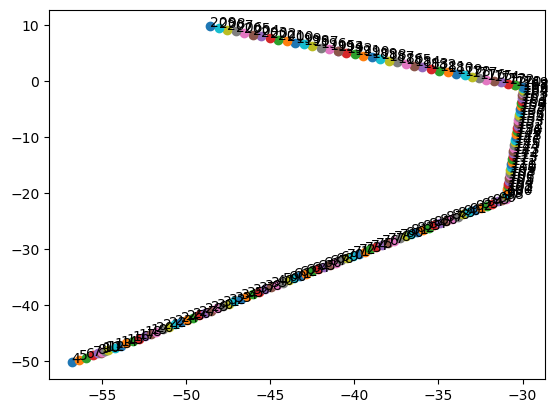

In [2]:
import matplotlib.pyplot as plt


remove_stations = (
    list(range(1, 3 + 1))  # segment a
    + list(range(41, 43 + 1))  # segment b
    + list(range(43, 58 + 1))  # segment c
    + list(range(115, 141 + 1))  # segment d
    + list(range(210, 235 + 1))  # segment h1/h2
)

groups = df.groupby("STNNBR")
fig, ax = plt.subplots()

for k, g in groups:
    if k not in remove_stations:
        ax.plot(g["LONGITUDE"].iloc[0], g["LATITUDE"].iloc[0], "o")
        ax.text(g["LONGITUDE"].iloc[0], g["LATITUDE"].iloc[0], s=str(k))

In [3]:
import gsw
import matplotlib.pyplot as plt
import numpy as np


def TS_prop(prop="OXYGEN"):
    fig, ax = plt.subplots(figsize=(9, 9))
    s = ax.scatter(df["SALNTY"], df["THETA"], s=50, c=df[prop], alpha=0.85)

    ax.set_xlabel("Salinidade")
    ax.set_ylabel("Temperatura Potencial (°C)")
    cbar = fig.colorbar(s, extend="both", shrink=0.9)

    npt = 100
    smin, smax, tmin, tmax = (
        min(df["SALNTY"]),
        max(df["SALNTY"]),
        min(df["THETA"]),
        max(df["THETA"]),
    )
    T = np.linspace(tmin - 1, tmax + 1, npt)
    S = np.linspace(smin - 1, smax + 1, npt)
    Tg, Sg = np.meshgrid(T, S)
    sigma_theta = gsw.sigma0(Sg, Tg)

    cs = ax.contour(Sg, Tg, sigma_theta, colors="grey", zorder=1, levels=12)
    ax.clabel(cs, fmt=r"σ=%.1f")

    kw = {"fontsize": 14, "fontweight": "black", "color": "purple"}
    props = {"boxstyle": "round", "facecolor": "wheat", "alpha": 0.5}
    arrowprops = {"arrowstyle": "->", "connectionstyle": "angle,angleA=0,angleB=90,rad=10"}

    offset = 40

    def annotate(ax, x, y, text, xytext=(2 * offset, offset), arrowprops=arrowprops):
        ax.annotate(
            text,
            (x, y),
            xytext=xytext,
            textcoords="offset points",
            bbox=props,
            arrowprops=arrowprops,
            **kw,
        )


    ax.text(35.4, 15, "ACAS", bbox=props, rotation=45, **kw)
    annotate(ax, 34.1, 3.5, "AIA", xytext=(2 * offset, 1.25 * offset))
    annotate(ax, 34.8, 3, "APAN")
    ax.text(34.9, -0.25, "AAF", bbox=props, **kw)
    annotate(
        ax,
        34.85,
        1.5,
        "LCPW",
        xytext=(offset, 0.3 * offset),
        arrowprops={"arrowstyle": "->"},
    )
    annotate(
        ax,
        34.75,
        2,
        "UCPW",
        xytext=(-2 * offset, -0.3 * offset),
        arrowprops={"arrowstyle": "->"},
    )


    ax.axis([33.5, 38, -1, 30])
    return fig, ax, cbar

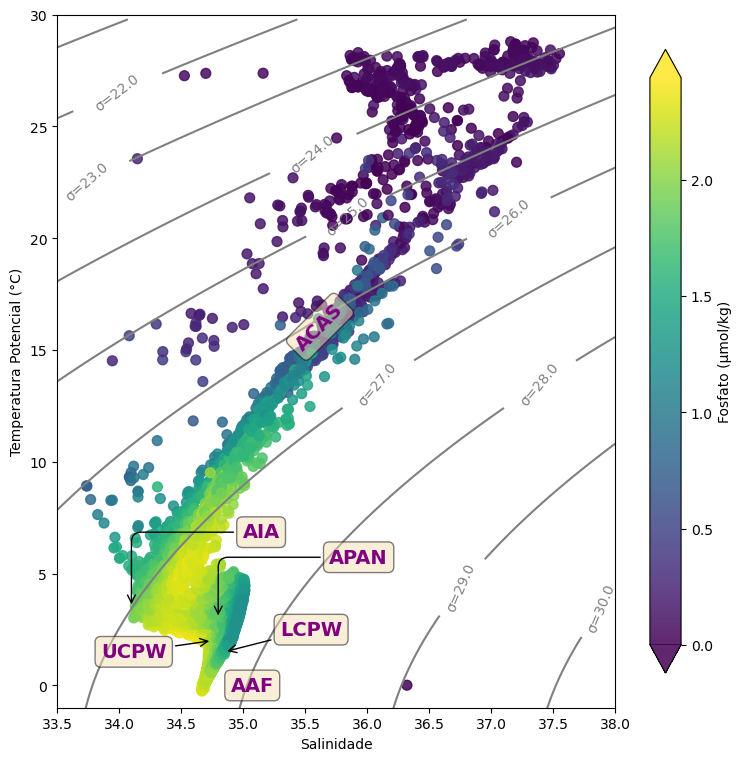

In [4]:
fig, ax, cbar = TS_prop(prop="PHSPHT")
cbar.set_label("Fosfato (µmol/kg)")

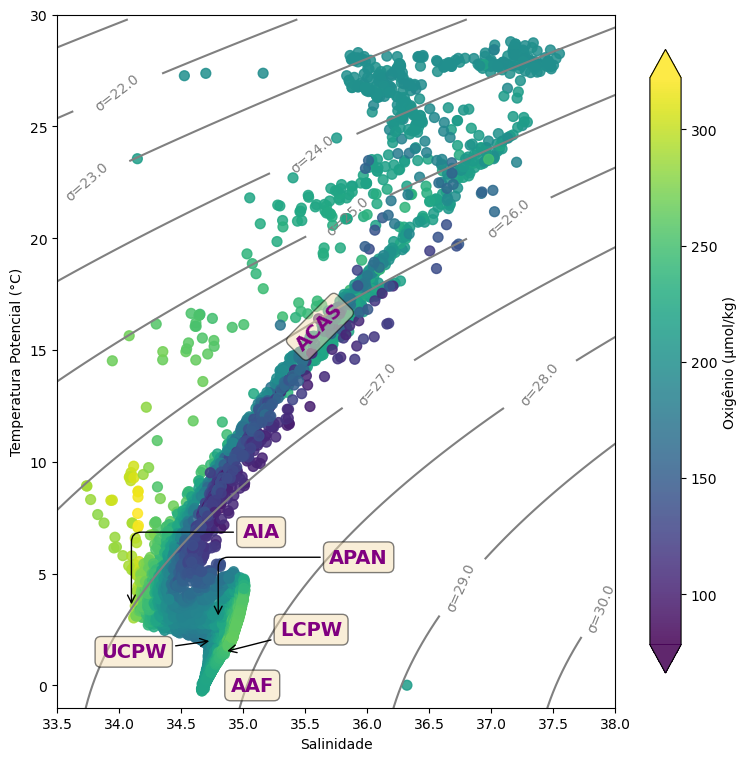

In [5]:
fig, ax, cbar = TS_prop(prop="OXYGEN")
cbar.set_label("Oxigênio (µmol/kg)")

In [6]:
from functools import reduce


groups = df.groupby("STNNBR")

oxygen = {}
salinity = {}
temperature = {}

depths = []
latitudes = []
longitudes = []

for station in set(df["STNNBR"]):
    # Remove the coastal trips checked with the commented plot above.
    if station not in remove_stations:
        lat, lon, depth = groups.get_group(station)[
            ["LATITUDE", "LONGITUDE", "DEPTH"]
        ].iloc[0]
        oxy = groups.get_group(station)[["CTDPRS", "OXYGEN"]].set_index("CTDPRS")
        salt = groups.get_group(station)[["CTDPRS", "SALNTY"]].set_index("CTDPRS")
        temp = groups.get_group(station)[["CTDPRS", "CTDTMP"]].set_index("CTDPRS")

        oxy.columns = [station]
        salt.columns = [station]
        temp.columns = [station]

        depths.append(depth)
        latitudes.append(lat)
        longitudes.append(lon)

        oxygen.update({station: oxy})
        salinity.update({station: salt})
        temperature.update({station: temp})

oxy = pd.concat(oxygen.values()).sort_index()
salt = pd.concat(salinity.values()).sort_index()
temp = pd.concat(temperature.values()).sort_index()

In [7]:
import numpy as np
import seawater as sw


oxy_data = np.ma.masked_invalid(oxy.values)
salt_data = np.ma.masked_invalid(salt.values)
temp_data = np.ma.masked_invalid(temp.values)

dist = sw.dist(latitudes, longitudes)
x = np.cumsum([0, *dist[0]])
z = oxy.index.values

In [8]:
oxy_filled = oxy.interpolate(method="linear")
salt_filled = salt.interpolate(method="linear")
temp_filled = temp.interpolate(method="linear")

In [9]:
def a17_section(interp, data, cmap, vmin=None, vmax=None, levels=None):
    fig, ax = plt.subplots(figsize=(17, 7))
    ax.invert_yaxis()
    cs = ax.pcolormesh(latitudes, z, interp, cmap=cmap, vmin=vmin, vmax=vmax)
    cbar = fig.colorbar(cs, extend="both", spacing="proportional")
    ax.fill_between(latitudes, depths, y2=max(z), color="black", zorder=99)

    vals = [-50, -40, -30, -20, -10, 0, 9.751]
    labels = ["50°S", "40°S", "30°S", "20°S", "10°S", "EQ", "10°N"]
    plt.xticks(vals, labels, color="k")

    for k, series in enumerate(data.values()):
        zz = series.index.to_numpy()
        xx = [latitudes[k]]* len(zz)
        ax.scatter(xx, zz, s=0.5, c="gray")
    
    return fig, ax, cbar

/tmp/ipykernel_214540/4157591807.py:4: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  cs = ax.pcolormesh(latitudes, z, interp, cmap=cmap, vmin=vmin, vmax=vmax)


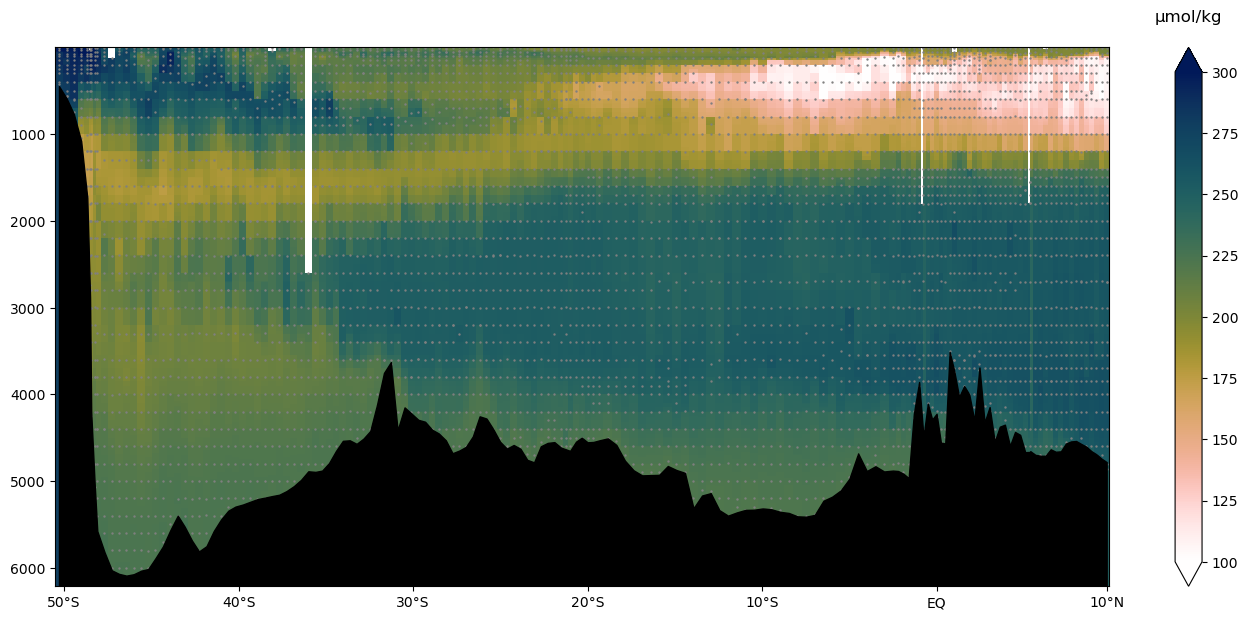

In [10]:
import cmcrameri.cm as cmc


cmap = cmc.batlowW_r
levels = np.linspace(100, 300, 15)

fig, ax, cbar = a17_section(interp=oxy_filled, data=oxygen, cmap=cmap, vmin=100, vmax=300, levels=levels)
cbar.ax.set_title("µmol/kg\n");

/tmp/ipykernel_214540/4157591807.py:4: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  cs = ax.pcolormesh(latitudes, z, interp, cmap=cmap, vmin=vmin, vmax=vmax)


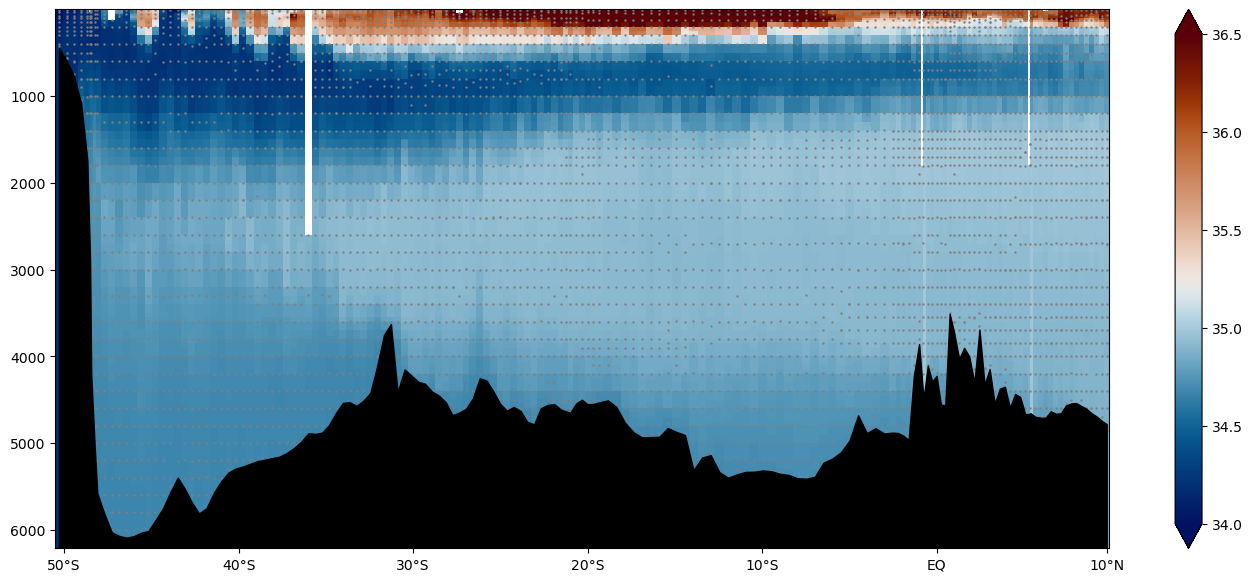

In [11]:
cmap = cmc.vik

fig, ax, cbar = a17_section(interp=salt_filled, data=salinity, cmap=cmap, vmin=34, vmax=36.5)
cbar.ax.set_title("");

/tmp/ipykernel_214540/4157591807.py:4: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  cs = ax.pcolormesh(latitudes, z, interp, cmap=cmap, vmin=vmin, vmax=vmax)


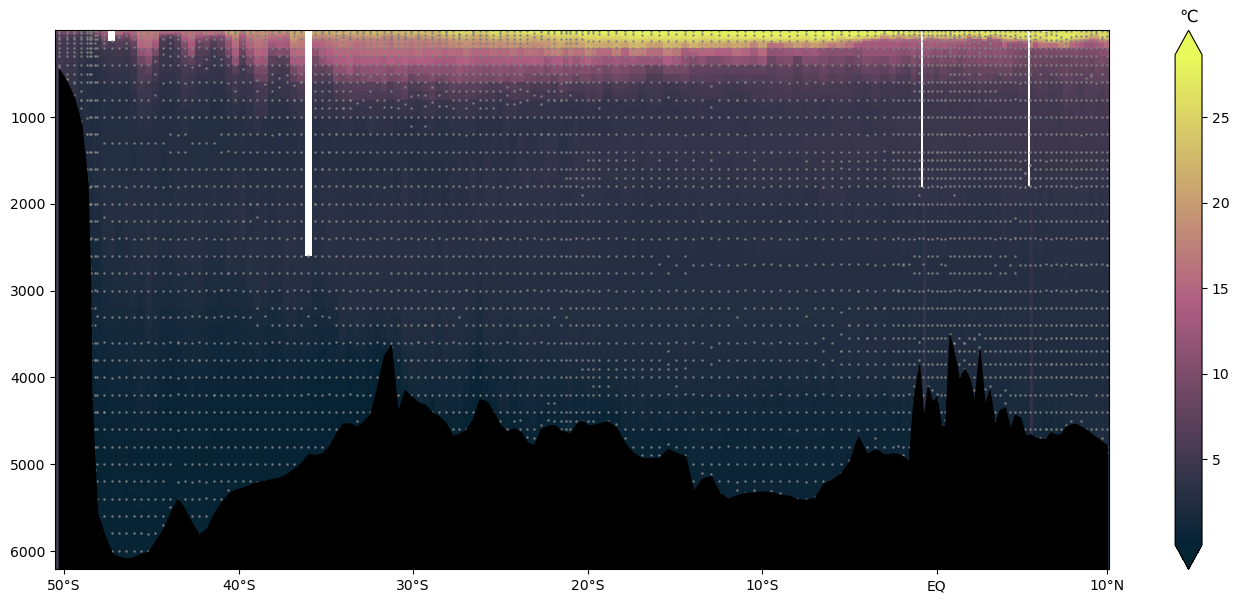

In [12]:
import palettable


cmap = palettable.cmocean.sequential.get_map("Thermal_3").mpl_colormap

fig, ax, cbar = a17_section(interp=temp_filled, data=temperature, cmap=cmap)
cbar.ax.set_title("℃");